# **Proyecto De Clasificacion**

## **Objetivo del Proyecto**
Desarrollar un modelo de clasificación de texto mediante técnicas de Procesamiento de Lenguaje Natural (PLN), capaz de detectar señales de riesgo suicida en publicaciones de redes sociales.

El objetivo es apoyar la detección temprana de ideación suicida a partir del análisis de lenguaje, utilizando un conjunto de datos etiquetado extraído de Reddit, y aplicar enfoques como TF-IDF, tokenización y modelos de clasificación como Naïve Bayes o Regresión Logística, con fines de apoyo a futuras estrategias de intervención en salud mental.

## **Descripción del Conjunto de Datos**

Este conjunto de datos contiene textos recopilados de publicaciones realizadas en foros de Reddit, especialmente en los subreddits *SuicideWatch* y *depression*. Cada registro representa una publicación de un usuario, con una etiqueta que indica si el contenido refleja señales asociadas a ideación suicida (`suicide`) o no (`non-suicide`).

- **Columnas**:
  - `Unnamed: 0`: Identificador numérico del registro (posiblemente un índice original).
  - `text`: Texto completo de la publicación escrita por el usuario.
  - `class`: Etiqueta de clasificación binaria (`suicide` o `non-suicide`), que indica si el contenido refleja un riesgo de suicidio.

- **Volumen de datos**: Aproximadamente 232,074 registros, lo que permite un análisis robusto al entrenar modelos de clasificación de texto.

- **Origen**: El dataset fue compartido públicamente en la plataforma Kaggle, y fue extraído mediante la API Pushshift.

Este conjunto de datos es especialmente útil para el desarrollo de modelos de clasificación en el ámbito de la salud mental, ya que permite entrenar algoritmos capaces de reconocer patrones lingüísticos asociados con situaciones de riesgo emocional.

---

## Librerias

In [1]:
import kagglehub
nikhileswarkomati_suicide_watch_path = kagglehub.dataset_download('nikhileswarkomati/suicide-watch')

c:\Users\artuk\OneDrive\Documentos\tarea\ESCOM\6S\MP\Proyecto Clasificacion\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Manipulación de Datos y Análisis Numérico
import pandas as pd
import numpy as np
import os
import re
import pickle
import string

# Procesamiento de Lenguaje Natural (NLP) y Embeddings
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize

from sentence_transformers import SentenceTransformer
import torch

# Machine Learning (Modelado, Preprocesamiento y Evaluación)
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif

# Modelos de Clasificación
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Manejo de Desbalanceo de Clases
from imblearn.over_sampling import SMOTE

# Métricas de Evaluación
from sklearn.metrics import classification_report, confusion_matrix

# Modelado de Tópicos
from sklearn.decomposition import LatentDirichletAllocation

# Visualización de Datos
import matplotlib.pyplot as plt
import seaborn as sns
import umap


# Utilidades y Configuración
import warnings

# Ignorar advertencias para una salida más limpia
warnings.filterwarnings('ignore')

In [3]:
import nltk

# Descarga los paquetes necesarios para tu código
nltk.download('punkt')          # Para tokenización (word_tokenize)
nltk.download('stopwords')      # Para la lista de palabras vacías
nltk.download('wordnet')        # Para la lematización (WordNetLemmatizer)
nltk.download('omw-1.4')        # Datos multilingües para WordNet

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\artuk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\artuk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\artuk\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\artuk\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Carga del dataset

In [4]:
# The dataset was downloaded to the path stored in nikhileswarkomati_suicide_watch_path
data = pd.read_csv(f'{nikhileswarkomati_suicide_watch_path}/Suicide_Detection.csv')
display(data.head())

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


## Evaluacion del dataset

In [5]:
#informacion del dataset
display(data.info())
display(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  232074 non-null  int64 
 1   text        232074 non-null  object
 2   class       232074 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB


None

,Unnamed: 0
count,232074.000000
mean,174152.863518
std,100500.425362
min,2.000000
25%,87049.250000
50%,174358.500000
75%,261285.750000
max,348110.000000


# Division de objetivos del dataset


En esta sección se realiza un análisis exploratorio para conocer la distribución de los casos de riesgo suicida según el género de quienes escriben las publicaciones. Esta visualización permite identificar posibles diferencias o patrones de comportamiento entre hombres y mujeres en cuanto a la expresión de pensamientos relacionados con la ideación suicida.

Se busca responder preguntas como:
- ¿Existe una mayor prevalencia de publicaciones con riesgo suicida en algún género?
- ¿El género influye en la frecuencia de mensajes clasificados como "suicide"?
- ¿Qué proporción representa cada clase dentro de cada género?

Este análisis es clave para orientar futuras estrategias de intervención y para comprender mejor cómo se manifiestan los riesgos de salud mental en diferentes grupos poblacionales.


## Analisis y visualizacion de suicidios por genero.



In [6]:
def clean_text(text):
    text = text.lower() # Convert to lowercase
    text = ''.join(ch for ch in text if ch.isalnum() or ch.isspace())
    return text

In [7]:
data_classification = data.copy()

In [8]:
#limpiar copia
data_classification['text']=data_classification['text'].apply(clean_text)

In [9]:
display(data_classification)

,Unnamed: 0,text,class
0,2,ex wife threatening suiciderecently i left my ...,suicide
1,3,am i weird i dont get affected by compliments ...,non-suicide
2,4,finally 2020 is almost over so i can never hea...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,im so losthello my name is adam 16 and ive bee...,suicide
...,...,...,...
232069,348103,if you dont like rock then your not going to g...,non-suicide
232070,348106,you how you can tell i have so many friends an...,non-suicide
232071,348107,pee probably tastes like salty tea can someone...,non-suicide
232072,348108,the usual stuff you find hereim not posting th...,suicide


### Creación de la Función de Etiquetado por Género

Se implementó una función heurística para identificar el género del autor de cada publicación, basada en frases de autoidentificación o referencias a relaciones de pareja. Esta estrategia permite enriquecer el análisis con una dimensión de género, incluso sin tener esta información explícita en los datos originales.


In [10]:
def assign_gender_v2(text):
    """
    Asigna un género con una lógica mejorada, considerando el contexto
    de auto-identificación y relaciones de pareja.
    """
    # Usamos el texto original (no limpio) para capturar mejor las frases.
    # str(text) previene errores si hay algún valor no textual.
    text_lower = ' ' + str(text).lower() + ' '

    # --- Nivel 1: Identificadores Fuertes (La persona se auto-identifica) ---
    self_id_male = [" i am a man", " i'm a man", " i am a guy", " i'm a guy", " as a man", " as a guy", " im a man", " im a guy"]
    self_id_female = [" i am a woman", " i'm a woman", " i am a girl", " i'm a girl", " as a woman", " as a girl", " im a woman", " im a girl"]

    is_male_self_id = any(keyword in text_lower for keyword in self_id_male)
    is_female_self_id = any(keyword in text_lower for keyword in self_id_female)

    # Si hay auto-identificación clara y no contradictoria, la usamos.
    if is_male_self_id and not is_female_self_id:
        return 'male'
    if is_female_self_id and not is_male_self_id:
        return 'female'

    # Nivel 2: Indicadores de Relación (Habla de su pareja)
    talks_about_male_partner = [' my boyfriend', ' my husband', ' he is my bf', ' hes my husband']
    talks_about_female_partner = [' my girlfriend', ' my wife', ' she is my gf', ' shes my wife']

    # Añadimos explícitamente el caso del texto 3 de ejemplo.
    # Esto es una heurística útil para el etiquetado a gran escala.
    mentions_male_partner = any(keyword in text_lower for keyword in talks_about_male_partner) or ' not for a boyfriend' in text_lower
    mentions_female_partner = any(keyword in text_lower for keyword in talks_about_female_partner)

    # Solo usamos este nivel si NO hubo auto-identificación en el Nivel 1.
    if not is_male_self_id and not is_female_self_id:
        # Si menciona una pareja masculina y no una femenina, es probable que la autora sea mujer.
        if mentions_male_partner and not mentions_female_partner:
            return 'female'
        # Si menciona una pareja femenina y no una masculina, es probable que el autor sea hombre.
        if mentions_female_partner and not mentions_male_partner:
            return 'male'

    # Si el texto es ambiguo o no contiene indicadores, devolvemos 'unknown'.
    return 'unknown'
# Usamos la copia 'data_classification' que ya creaste y limpiaste
data_classification['gender'] = data_classification['text'].apply(assign_gender_v2)

# Veamos cuántos hemos podido etiquetar
print("Distribución de género etiquetado:")
print(data_classification['gender'].value_counts())

Distribución de género etiquetado:
gender
unknown    222211
male         5390
female       4473
Name: count, dtype: int64


Esto indica que aproximadamente el 4 % de los textos pudieron ser clasificados como escritos por hombres o mujeres, mientras que en más del 95 % de los casos no se encontró suficiente evidencia lingüística para determinar el género, lo cual es esperable en textos anónimos y no estructurados.


In [11]:
# Muestra una observacion que sea hombre su texto unicamente

# Filtrar las observaciones donde el género es 'male'
male_observations = data_classification[data_classification['gender'] == 'male']

# Mostrar el texto de la primera observación etiquetada como 'male'
if not male_observations.empty:
    print("\nTexto de una observación de hombre:")
    print(male_observations.iloc[120]['text'])
else:
    print("\nNo se encontraron observaciones etiquetadas como 'male'.")



Texto de una observación de hombre:
i lost everything and have nothing to look forward tolast month my girlfriend of 3 12 years broke up with me i understand why i was an asshole a lot of the time and she wanted something different she was my everything and i thought i was hers but i guess not i truly do want her to be happy but thinking about it i highly doubt she thinks that means me im only 19 and im sure id at some point id find someone better but all i want is her ive tried to get better and be better in hopes of being a bit happier and maybe getting back together with her exercising getting a job making new friends therapy etc but each thing that goes well in my life makes me feel more and more like shit i wake up depressed and force myself to put on smile and talk normally to people in my class but its getting increasingly difficult all i want to do is talk to audrey just tell her about my day and ask about hers but she doesnt even want to talk to me anymore im terrified of the

Este texto fue clasificado como escrito por un hombre debido a la referencia a una exnovia (“my girlfriend”), lo cual fue interpretado por el modelo como un indicio de género masculino.


La función logró clasificar correctamente miles de casos donde había frases claras, lo que permite segmentar el análisis y explorar posibles diferencias en la forma en que se expresa el riesgo suicida.


### Uso de datos etiquetados para clasificar a los que no son clasificados

### **Distribución por Género y Tipo de Publicación**

Se filtran los textos con género identificado y se grafica la cantidad de publicaciones `suicide` y `non-suicide` por género.


Total de textos etiquetados por género: 9863


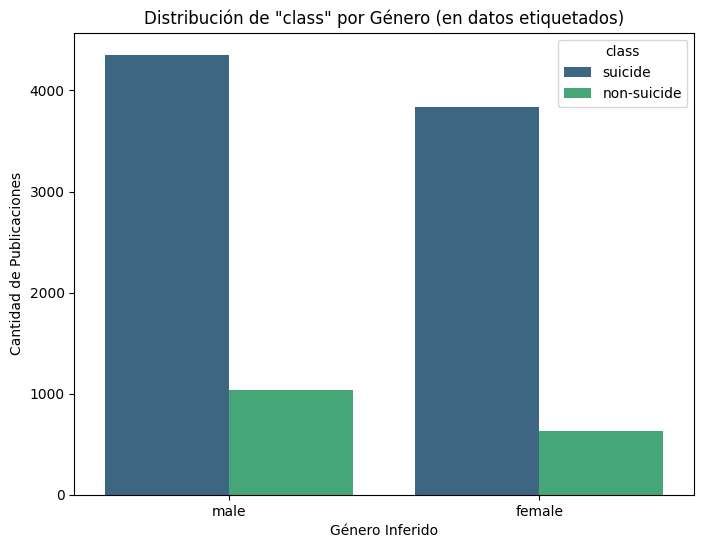


Proporción de 'suicide' vs 'non-suicide' por género:
class   non-suicide   suicide
gender                       
female     0.141292  0.858708
male       0.192208  0.807792


In [12]:
# Crear un nuevo DataFrame solo con los datos que pudimos etiquetar
data_gender_labeled = data_classification[data_classification['gender'] != 'unknown']

print(f'\nTotal de textos etiquetados por género: {len(data_gender_labeled)}')

# Análisis: ¿Hay una diferencia en la tendencia suicida entre géneros en nuestro subconjunto?
plt.figure(figsize=(8, 6))
sns.countplot(data=data_gender_labeled, x='gender', hue='class', palette='viridis')
plt.title('Distribución de "class" por Género (en datos etiquetados)')
plt.xlabel('Género Inferido')
plt.ylabel('Cantidad de Publicaciones')
plt.show()

# También puedes ver la proporción
gender_class_dist = data_gender_labeled.groupby('gender')['class'].value_counts(normalize=True).unstack()
print("\nProporción de 'suicide' vs 'non-suicide' por género:")
print(gender_class_dist)

La visualización ya muestra que los hombres presentan un mayor número de publicaciones con señales de riesgo en este subconjunto.

Además, la proporción confirma que, aunque ambos géneros tienen una alta prevalencia de mensajes de riesgo, el porcentaje de publicaciones suicidas es ligeramente mayor en mujeres (86 %) que en hombres (80 %).


### **Clasificación de Género a partir del Texto**

Se entrenó un modelo Naive Bayes usando textos previamente etiquetados por género.


--- Reporte de Clasificación del Modelo de Género ---
              precision    recall  f1-score   support

      female       0.94      0.76      0.84       895
        male       0.83      0.96      0.89      1078

    accuracy                           0.87      1973
   macro avg       0.89      0.86      0.87      1973
weighted avg       0.88      0.87      0.87      1973



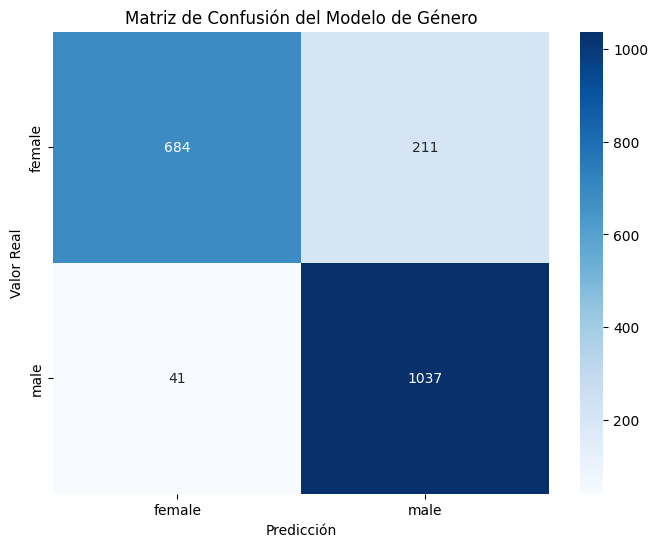

In [13]:
# Preparar los datos para el modelo de género
# Usaremos el DataFrame con las etiquetas que creamos
df_gender_model = data_classification[data_classification['gender'] != 'unknown'].copy()
df_gender_model.dropna(inplace=True) # Eliminar filas con valores nulos si las hay

# Dividir en Features (X) y Target (y)
X_gender = df_gender_model['text']
y_gender = df_gender_model['gender']

# Vectorización del texto
tfidf_gender = TfidfVectorizer(max_features=5000, stop_words='english')
X_gender_tfidf = tfidf_gender.fit_transform(X_gender)

# Dividir en entrenamiento y prueba
X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X_gender_tfidf, y_gender, test_size=0.2, random_state=42, stratify=y_gender)

# Entrenar un clasificador (Multinomial Naive Bayes es un buen punto de partida)
model_gender = MultinomialNB()
model_gender.fit(X_train_g, y_train_g)

# Evaluar el modelo
y_pred_g = model_gender.predict(X_test_g)
print("\n--- Reporte de Clasificación del Modelo de Género ---")
print(classification_report(y_test_g, y_pred_g))

# Mostrar matriz en seaborn
cm_gender = confusion_matrix(y_test_g, y_pred_g)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gender, annot=True, fmt='d', cmap='Blues', xticklabels=['female', 'male'], yticklabels=['female', 'male'])
plt.title('Matriz de Confusión del Modelo de Género')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

El modelo obtuvo un **87 % de precisión**, destacando una alta capacidad para identificar correctamente textos escritos por hombres (recall 0.96), aunque tiene más errores al predecir textos femeninos.


Para el desbalanceo se uso pesos por clase:

Este es un enfoque más simple. En lugar de cambiar los datos, le decimos al algoritmo de entrenamiento que penalice más los errores en la clase minoritaria. Es como decirle al modelo: "Equivocarte con un male es el doble de grave que equivocarte con un female".

Muchos clasificadores en scikit-learn tienen el parámetro class_weight='balanced'. El modelo calculará automáticamente el peso necesario para balancear las clases.


--- Reporte de Clasificación del Modelo con Class Weight ---
              precision    recall  f1-score   support

      female       0.98      0.94      0.96       895
        male       0.95      0.98      0.97      1078

    accuracy                           0.96      1973
   macro avg       0.96      0.96      0.96      1973
weighted avg       0.96      0.96      0.96      1973



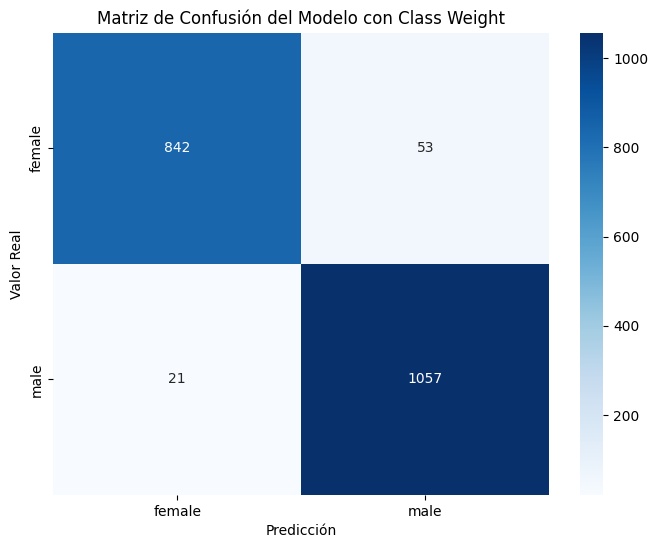

In [14]:
# Usaremos RandomForestClassifier que funciona muy bien con esta opción.

# Inicializar el modelo con el parámetro de peso
# No necesitamos SMOTE ni remuestreo aquí. Usamos los datos de entrenamiento originales.
model_gender_weighted = RandomForestClassifier(random_state=42, class_weight='balanced')

# Entrenar el modelo con los datos originales (desbalanceados)
model_gender_weighted.fit(X_train_g, y_train_g)

# Evaluar el modelo en el conjunto de prueba
y_pred_weighted = model_gender_weighted.predict(X_test_g)

print("\n--- Reporte de Clasificación del Modelo con Class Weight ---")
print(classification_report(y_test_g, y_pred_weighted))

# Mostrar matriz con seaborn
cm_weighted = confusion_matrix(y_test_g, y_pred_weighted)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_weighted, annot=True, fmt='d', cmap='Blues', xticklabels=['female', 'male'], yticklabels=['female', 'male'])
plt.title('Matriz de Confusión del Modelo con Class Weight')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

Al aplicar `class_weight='balanced'`, el modelo logró una mayor precisión general (96 %). Este ajuste compensó el desbalance entre clases, mejorando especialmente la predicción de textos escritos por mujeres (recall subió de 0.76 a 0.94), sin afectar negativamente la predicción de hombres. La matriz de confusión muestra menos errores en ambas clases.


### Clasificar textos de genero desconocido

Aplicamos

In [15]:
# Filtrar los datos que necesitan clasificación (aquellos cuyo género es 'unknown')
data_to_predict = data_classification[data_classification['gender'] == 'unknown'].copy()

print(f"Número de textos a clasificar: {len(data_to_predict)}")

Número de textos a clasificar: 222211


In [16]:
# Extraer el texto de los datos que queremos clasificar
X_unknown_text = data_to_predict['text']

# Usar el vectorizador YA ENTRENADO para transformar este nuevo texto
X_unknown_tfidf = tfidf_gender.transform(X_unknown_text)


In [17]:
# Usar el modelo entrenado para predecir el género
unknown_gender_predictions = model_gender_weighted.predict(X_unknown_tfidf)
print(f"Se generaron {len(unknown_gender_predictions)} nuevas etiquetas.")

Se generaron 222211 nuevas etiquetas.


In [18]:
# Asignar las predicciones de vuelta al DataFrame original en las filas correspondientes
# .loc es la forma más segura y recomendada de hacer esta asignación
data_classification.loc[data_classification['gender'] == 'unknown', 'gender'] = unknown_gender_predictions

# Verificar la nueva distribución de la columna 'gender'. Ya no debería haber 'unknowns'.
print("\nDistribución de género final (después de la predicción):")
print(data_classification['gender'].value_counts())


Distribución de género final (después de la predicción):
gender
male      163189
female     68885
Name: count, dtype: int64


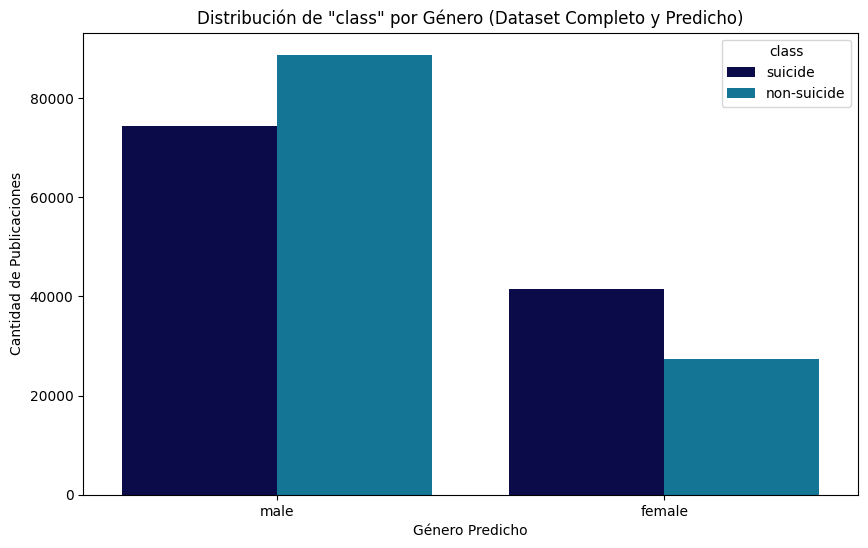


Proporción final de 'suicide' vs 'non-suicide' por género:
class   non-suicide   suicide
gender                       
female     0.396197  0.603803
male       0.543817  0.456183


In [19]:
# análisis sobre el dataset

plt.figure(figsize=(10, 6))
sns.countplot(data=data_classification, x='gender', hue='class', palette='ocean')
plt.title('Distribución de "class" por Género (Dataset Completo y Predicho)')
plt.xlabel('Género Predicho')
plt.ylabel('Cantidad de Publicaciones')
plt.show()

# También puedes calcular las proporciones finales
final_dist = pd.crosstab(data_classification['gender'], data_classification['class'], normalize='index')
print("\nProporción final de 'suicide' vs 'non-suicide' por género:")
print(final_dist)

### Predicción Final de Género

Tras aplicar el modelo con balanceo de clases, se generaron 222,211 nuevas etiquetas de género para los textos desconocidos. La mayoría fueron clasificadas como `male`.

### Proporciones de riesgo:
- En mujeres, el 60 % de los textos fueron `suicide`.
- En hombres, el 45 % fueron `suicide`.

Esto permite un análisis más completo por género en todo el conjunto de datos.


Filtramos algunos textos de prueba ya clasificados

In [20]:
# Filtrar textos para cada categoría de género
male_texts = data_classification[data_classification['gender'] == 'male']['text'].sample(n=min(3, len(data_classification[data_classification['gender'] == 'male'])), random_state=45).tolist()
female_texts = data_classification[data_classification['gender'] == 'female']['text'].sample(n=min(3, len(data_classification[data_classification['gender'] == 'female'])), random_state=45).tolist()

# Imprimir los textos de ejemplo
print("\n--- Textos de ejemplo para el género 'male' ---")
for i, text in enumerate(male_texts):
    print(f"Texto {i+1}: {text}") # Imprimir solo los primeros 200 caracteres para brevedad

print("\n--- Textos de ejemplo para el género 'female' ---")
for i, text in enumerate(female_texts):
    print(f"Texto {i+1}: {text}") # Imprimir solo los primeros 200 caracteres para brevedad



--- Textos de ejemplo para el género 'male' ---
Texto 1: dehydrationhavent had anything to eat or drink for 2 days just hoping the hunger goes away soon so i can just let  my organs shut themselves off and go to fucking sleep
Texto 2: my plani am 14 and am killing myself on the 26th i just want to share my plan i will hang my self on the tree outside at midnight between the 26th and 27th i have made my mind up i just need to buy the rope
Texto 3: teachers dont get enough credit i may be kinda bias bc both my parents are teachers but especially right now i feel they dont get the respect they deserve they are really putting their health on the line bc they wanna see us and set us up for life and i think thats pretty cool of them thank you for listening to my ted talk

--- Textos de ejemplo para el género 'female' ---
Texto 1: do you guys believe class rings are worth itwhy or why not im a junior in high school and im considering getting a class ring im just not sure theyre worth the 300

## Visualizacion y analisis de suicidios por edad

In [21]:
display(  data_classification)

,Unnamed: 0,text,class,gender
0,2,ex wife threatening suiciderecently i left my ...,suicide,male
1,3,am i weird i dont get affected by compliments ...,non-suicide,male
2,4,finally 2020 is almost over so i can never hea...,non-suicide,male
3,8,i need helpjust help me im crying so hard,suicide,female
4,9,im so losthello my name is adam 16 and ive bee...,suicide,female
...,...,...,...,...
232069,348103,if you dont like rock then your not going to g...,non-suicide,male
232070,348106,you how you can tell i have so many friends an...,non-suicide,male
232071,348107,pee probably tastes like salty tea can someone...,non-suicide,male
232072,348108,the usual stuff you find hereim not posting th...,suicide,male


### Extracción y Agrupación por Edad

Para el análisis por edad, se creó una función que extrae valores numéricos utilizando expresiones regulares y genera la columna `age`. Luego, se clasificaron los textos en grupos de edad: Teenager, Young Adult, Adult y Older Adult.


In [22]:
import re

def extract_age(text):
    """
    Versión mejorada para extraer edad con más patrones y contexto.
    """
    text_lower = ' ' + str(text).lower() + ' '
    
    # Patrones más específicos y exhaustivos
    patterns = [
        r'\b(?:i am|i\'m|im)\s*\(?(\d{1,2})\)?\s*(?:years? old|yo)?\b',
        r'\bmy age is\s*(\d{1,2})\b',
        r'\bage\s*(\d{1,2})\b',
        r'\b(\d{1,2})\s*years? old\b',
        r'\b(\d{1,2})\s*yo\b',
        r'\b(\d{1,2})\s*(?:years?|yrs?)\b',
        r'\b(?:i\'m|i am|im)\s*(\d{1,2})\b',
        r'\b(\d{1,2})\s*(?:m|f)\b',  # Patrones como "25m" o "30f"
        r'\b(?:a|an)\s*(\d{1,2})\s*(?:year|yr)-old\b'
    ]
    
    for pattern in patterns:
        match = re.search(pattern, text_lower)
        if match:
            age = int(match.group(1))
            # Validar que la edad sea razonable
            if 10 <= age <= 100:
                return age
    
    return None

# Aplicamos la función para crear la nueva columna 'age'
data_classification['age'] = data_classification['text'].apply(extract_age)

In [23]:
# --- PASO 1: Crear una nueva función de clasificación de edad ---

def classify_age_group_v3(age):
    """
    Clasificación de edad combinando las categorías de adultos.
    """
    if pd.isna(age):
        return 'unknown'
    age = int(age)
    if age <= 16:
        return 'Adolescent (<=16)'
    elif 17 <= age <= 20:
        return 'Young Teen (17-20)'
    elif 21 <= age <= 30:
        return 'Young Adult (21-30)'
    # Combinamos Adult (31-45) y Older Adult (>45) en una sola categoría
    elif age > 30:
        return 'Adult (>30)'
    else:
        return 'unknown' # Por si acaso

# --- PASO 2: Aplicar la nueva función a tu DataFrame ---

# Asegúrate de que la columna 'age' existe en tu DataFrame
# data_classification['age'] = data_classification['text'].apply(extract_age_improved) # Si no lo has hecho ya

# Aplicamos la nueva clasificación
data_classification['age_group_v3'] = data_classification['age'].apply(classify_age_group_v3)


In [24]:
# --- PASO 3: Repetir el flujo de entrenamiento con las nuevas categorías ---

# Crear un DataFrame solo con los datos que tienen un grupo de edad conocido
df_age_labeled_v3 = data_classification[data_classification['age_group_v3'] != 'unknown'].copy()

print("Nueva distribución de datos etiquetados por edad:")
print(df_age_labeled_v3['age_group_v3'].value_counts())

# Definir Features (X) y Target (y)
X_age_v3 = df_age_labeled_v3['text']
y_age_v3 = df_age_labeled_v3['age_group_v3']

# Dividir en entrenamiento y prueba
X_train_age_v3, X_test_age_v3, y_train_age_v3, y_test_age_v3 = train_test_split(
    X_age_v3, y_age_v3, test_size=0.2, random_state=42, stratify=y_age_v3
)

# Vectorizar el texto
tfidf_age_v3 = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_age_tfidf_v3 = tfidf_age_v3.fit_transform(X_train_age_v3)
X_test_age_tfidf_v3 = tfidf_age_v3.transform(X_test_age_v3)

# Entrenar el modelo RandomForest con class_weight='balanced'
# Usamos los datos de entrenamiento originales (desbalanceados)
model_weighted_v3 = RandomForestClassifier(
    random_state=42,
    n_estimators=200,
    class_weight='balanced'
)

model_weighted_v3.fit(X_train_age_tfidf_v3, y_train_age_v3)



Nueva distribución de datos etiquetados por edad:
age_group_v3
Adolescent (<=16)      7852
Young Teen (17-20)     6185
Young Adult (21-30)    6130
Adult (>30)            2365
Name: count, dtype: int64


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


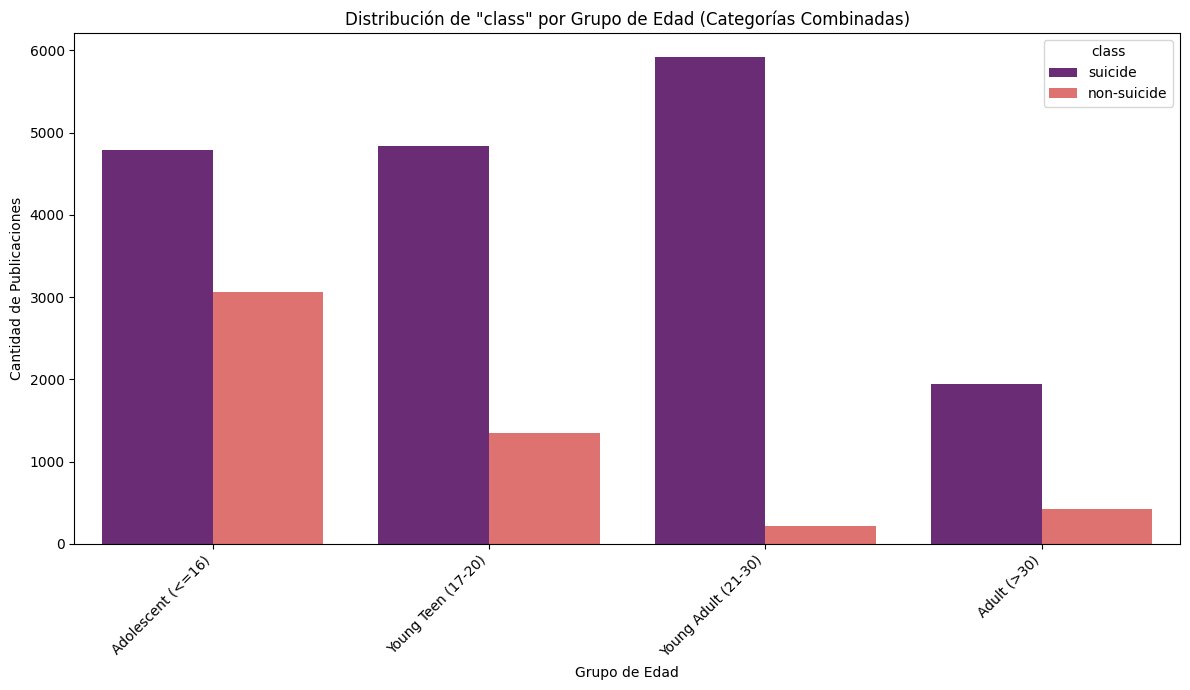


Proporción de 'suicide' vs 'non-suicide' por Grupo de Edad:
class                non-suicide   suicide
age_group_v3                              
Adolescent (<=16)       0.390474  0.609526
Young Teen (17-20)      0.217462  0.782538
Young Adult (21-30)     0.034910  0.965090
Adult (>30)             0.177590  0.822410


In [25]:
# 1. Define el nuevo orden lógico de tus categorías.
#    Ajusta el nombre de la categoría combinada.
age_order_v3 = [
    'Adolescent (<=16)',
    'Young Teen (17-20)',
    'Young Adult (21-30)',
    'Adult (>30)'  
]

# 2. Filtra los datos usando la NUEVA columna 'age_group_v3'
data_age_labeled_v3 = data_classification[data_classification['age_group_v3'] != 'unknown'].copy()

# Análisis: ¿Hay una diferencia en la tendencia suicida entre grupos de edad?
plt.figure(figsize=(12, 7))

# 3. Usa la lista 'age_order_v3' y la NUEVA columna 'age_group_v3' en el countplot.
sns.countplot(data=data_age_labeled_v3, x='age_group_v3', hue='class', palette='magma', order=age_order_v3)
plt.title('Distribución de "class" por Grupo de Edad (Categorías Combinadas)') # Título actualizado para reflejar el cambio
plt.xlabel('Grupo de Edad')
plt.ylabel('Cantidad de Publicaciones')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 4. Calcula las proporciones usando la NUEVA columna 'age_group_v3'
age_class_dist_v3 = data_age_labeled_v3.groupby('age_group_v3')['class'].value_counts(normalize=True).unstack().fillna(0)

# 5. Reordena el índice del DataFrame para que coincida con el gráfico.
age_class_dist_ordered_v3 = age_class_dist_v3.reindex(age_order_v3)

print("\nProporción de 'suicide' vs 'non-suicide' por Grupo de Edad:")
print(age_class_dist_ordered_v3)


Reporte de Clasificación
                     precision    recall  f1-score   support

  Adolescent (<=16)       0.82      0.86      0.84      1571
        Adult (>30)       0.96      0.38      0.55       473
Young Adult (21-30)       0.79      0.90      0.84      1226
 Young Teen (17-20)       0.85      0.88      0.87      1237

           accuracy                           0.83      4507
          macro avg       0.86      0.76      0.77      4507
       weighted avg       0.84      0.83      0.82      4507



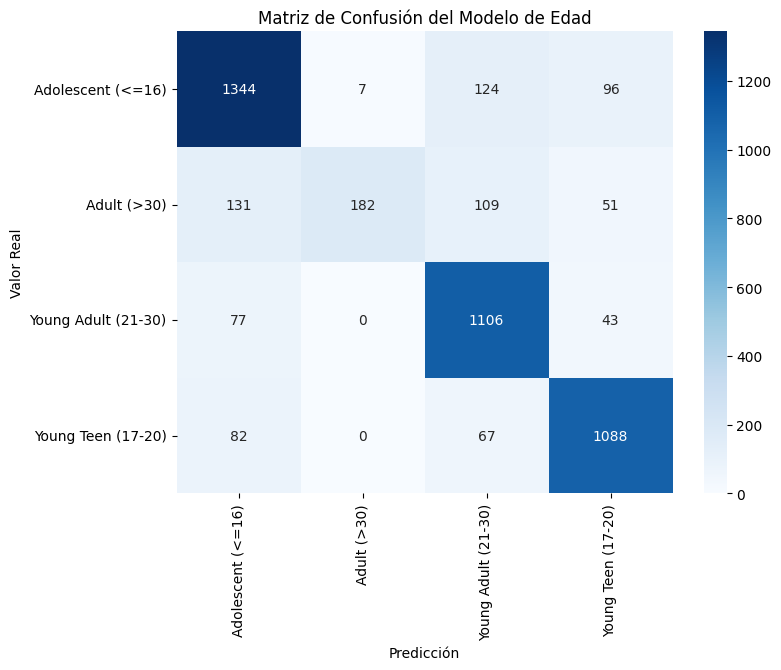

In [26]:
# Evaluar el modelo
y_pred_weighted_v3 = model_weighted_v3.predict(X_test_age_tfidf_v3)

print("\nReporte de Clasificación")
print(classification_report(y_test_age_v3, y_pred_weighted_v3))

# Opcional: Mostrar la nueva matriz de confusión
cm_v3 = confusion_matrix(y_test_age_v3, y_pred_weighted_v3)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_v3, annot=True, fmt='d', cmap='Blues', xticklabels=model_weighted_v3.classes_, yticklabels=model_weighted_v3.classes_)
plt.title('Matriz de Confusión del Modelo de Edad')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

###  Interpretación:
La tabla revela una tendencia preocupante y consistente: en todos los grupos de edad analizados, la proporción de publicaciones relacionadas con el suicidio es notablemente superior a las que no lo son. El hallazgo más alarmante se observa en el grupo de 'Young Adult (21-30)', donde la inmensa mayoría de las publicaciones (96.5%) tratan sobre suicidio, lo que sugiere un punto álgido en la vulnerabilidad o la expresión de estos problemas durante esta etapa de la vida. Se observa una clara progresión ascendente desde el grupo 'Adolescent (<=16)' ** (60.9%) hasta el de adultos jóvenes. Aunque se observa una ligera disminución en el grupo ** 'Adult (>30)', la proporción se mantiene extremadamente alta (82.2%), lo que confirma que se trata de un problema persistente y generalizado a lo largo de todas las etapas de la adultez en este conjunto de datos.


### Clasificar desconocidos con estos datos ya etiquetados

### ¿Hay una diferencia en la tendencia suicida entre grupos de edad?

Sí, la gráfica muestra diferencias claras entre los grupos. Los adolescentes (≤17) y jóvenes adultos (18–25) concentran la mayoría de las publicaciones, y en ambos grupos predomina la clase `suicide`.

En adultos y mayores de 40 años, aunque hay menos publicaciones, el porcentaje de `suicide` es incluso más marcado en relación al total. Esto sugiere que las señales de riesgo suicida están presentes en todas las edades, pero con mayor volumen en los grupos jóvenes.


### Clasificacion de edad a desconocidos

### Entrenar modelo de clasificacion

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Crear un DataFrame solo con los datos que tienen un grupo de edad conocido.
df_age_labeled = data_classification[data_classification['age_group_v3'] != 'unknown'].copy()

print("Datos etiquetados por edad que se usarán para el entrenamiento:")
# 2. Este 'value_counts()' ahora mostrará la distribución de tus NUEVAS categorías.
print(df_age_labeled['age_group_v3'].value_counts())

# Definir Features (X) y Target (y)
X_age = df_age_labeled['text']
y_age = df_age_labeled['age_group_v3']

# Dividir en entrenamiento y prueba.
# Se usa 'stratify=y_age' para asegurar que el desbalance de clases
# se mantenga igual en los conjuntos de entrenamiento y prueba.
# 4. 'stratify' funcionará perfectamente con las nuevas etiquetas en 'y_age'.
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(
    X_age, y_age, test_size=0.2, random_state=42, stratify=y_age
)

# Puedes verificar que la estratificación funcionó
print("\nDistribución en el conjunto de entrenamiento:")
print(y_train_age.value_counts(normalize=True))

print("\nDistribución en el conjunto de prueba:")
print(y_test_age.value_counts(normalize=True))

Datos etiquetados por edad que se usarán para el entrenamiento:
age_group_v3
Adolescent (<=16)      7852
Young Teen (17-20)     6185
Young Adult (21-30)    6130
Adult (>30)            2365
Name: count, dtype: int64

Distribución en el conjunto de entrenamiento:
age_group_v3
Adolescent (<=16)      0.348460
Young Teen (17-20)     0.274508
Young Adult (21-30)    0.272067
Adult (>30)            0.104965
Name: proportion, dtype: float64

Distribución en el conjunto de prueba:
age_group_v3
Adolescent (<=16)      0.348569
Young Teen (17-20)     0.274462
Young Adult (21-30)    0.272021
Adult (>30)            0.104948
Name: proportion, dtype: float64


En este caso como adultos viejos tiene muy pocos casos usamos smote

### Asignar edades a los datos desconocidos

In [28]:
# Aislar los datos con 'age_group_v3' desconocido
data_age_to_predict = data_classification[data_classification['age_group_v3'] == 'unknown'].copy()
print(f"\nNúmero de textos con edad desconocida a clasificar: {len(data_age_to_predict)}")

# Extraer y transformar el texto usando el NUEVO vectorizador 'tfidf_age_v3'
X_unknown_age_text = data_age_to_predict['text']
X_unknown_age_tfidf = tfidf_age_v3.transform(X_unknown_age_text)

# Realizar las predicciones con el NUEVO modelo de edad
unknown_age_predictions = model_weighted_v3.predict(X_unknown_age_tfidf)

# Asignar las predicciones de vuelta al DataFrame original en la columna correcta
data_classification.loc[data_classification['age_group_v3'] == 'unknown', 'age_group_v3'] = unknown_age_predictions

# Verificar la nueva distribución final
print("\nDistribución de grupo de edad final (después de la predicción):")
print(data_classification['age_group_v3'].value_counts())


Número de textos con edad desconocida a clasificar: 209542

Distribución de grupo de edad final (después de la predicción):
age_group_v3
Adolescent (<=16)      181647
Young Adult (21-30)     30888
Young Teen (17-20)      14372
Adult (>30)              5167
Name: count, dtype: int64


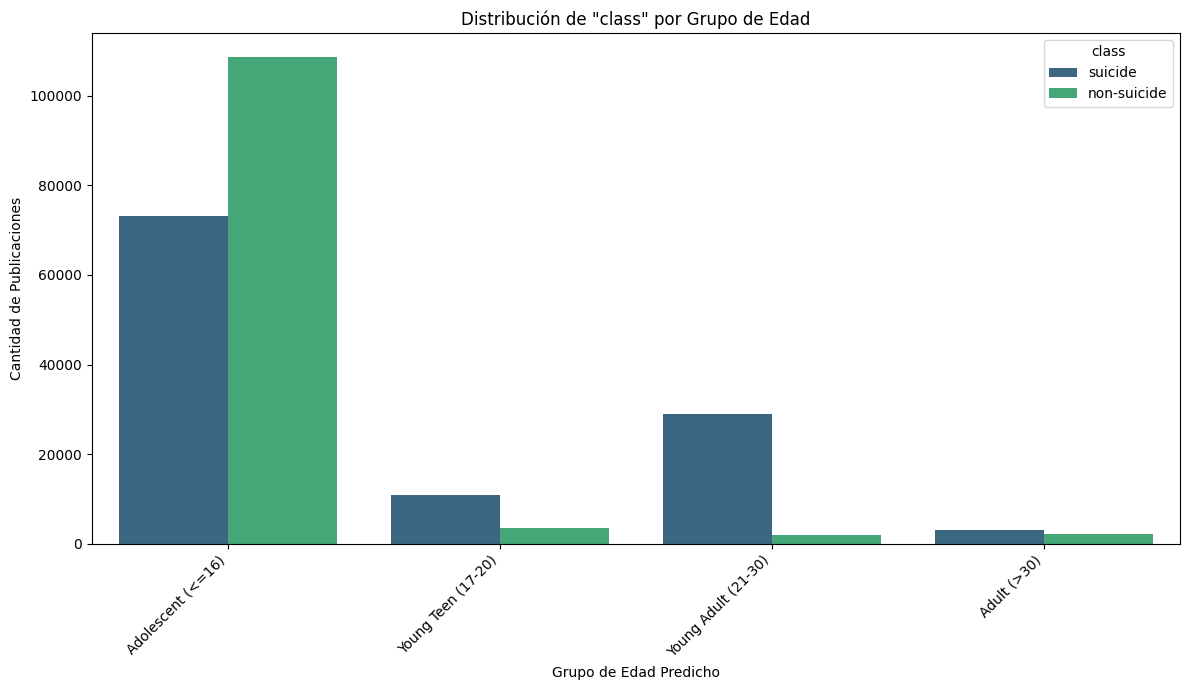

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define el orden correcto de tus categorías FINALES (de age_group_v3)
age_order_final = [
    'Adolescent (<=16)',
    'Young Teen (17-20)',
    'Young Adult (21-30)',
    'Adult (>30)'
]

plt.figure(figsize=(12, 7))

# El resto del código es correcto, pero usará la nueva lista 'age_order_final'
sns.countplot(data=data_classification, x='age_group_v3', hue='class', palette='viridis', order=age_order_final)

plt.title('Distribución de "class" por Grupo de Edad')
plt.xlabel('Grupo de Edad Predicho')
plt.ylabel('Cantidad de Publicaciones')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Comparación de Distribución por Edad (Real vs. Predicho)

Al comparar los datos etiquetados manualmente con los datos predichos por el modelo de edad, se observan algunas diferencias importantes:

- En los **datos reales**, la mayoría de publicaciones clasificadas como `suicide` provienen de jóvenes adultos (18–25) y adolescentes (≤17).
- En los **datos predichos**, el grupo adolescente tiene un alto volumen de publicaciones, pero ahora predominan los mensajes `non-suicide`. Este cambio puede deberse a un sesgo del modelo o a la naturaleza menos explícita de ciertos textos.

En general, los grupos adultos y mayores se mantienen con menor volumen en ambos casos, lo que refuerza que las publicaciones con contenido sensible están más concentradas en edades jóvenes.

Este contraste resalta la utilidad del modelo para ampliar el análisis, pero también invita a revisar su precisión y el contexto en que se usa.


In [30]:
display(data_classification)

,Unnamed: 0,text,class,gender,age,age_group_v3
0,2,ex wife threatening suiciderecently i left my ...,suicide,male,NaN,Adolescent (<=16)
1,3,am i weird i dont get affected by compliments ...,non-suicide,male,NaN,Adolescent (<=16)
2,4,finally 2020 is almost over so i can never hea...,non-suicide,male,NaN,Adolescent (<=16)
3,8,i need helpjust help me im crying so hard,suicide,female,NaN,Adolescent (<=16)
4,9,im so losthello my name is adam 16 and ive bee...,suicide,female,NaN,Adolescent (<=16)
...,...,...,...,...,...,...
232069,348103,if you dont like rock then your not going to g...,non-suicide,male,NaN,Adolescent (<=16)
232070,348106,you how you can tell i have so many friends an...,non-suicide,male,NaN,Adolescent (<=16)
232071,348107,pee probably tastes like salty tea can someone...,non-suicide,male,NaN,Adolescent (<=16)
232072,348108,the usual stuff you find hereim not posting th...,suicide,male,18.0,Young Teen (17-20)


## Análisis de Sentimiento (Polaridad y Subjetividad)

Al intentar con el dataset completo decidimos usar la mitad para las pruebas ya que con el data completo no podia compilar

In [31]:
# Separar el dataset en las dos clases
df_suicide = data_classification[data_classification['class'] == 'suicide']
df_non_suicide = data_classification[data_classification['class'] == 'non-suicide']

# Tomar una muestra aleatoria del 50% de cada clase
# frac=0.5 significa que tomamos el 50% de las filas.
# random_state asegura que si lo ejecutas de nuevo, obtengas la misma muestra.
sample_suicide = df_suicide.sample(frac=0.05, random_state=42)
sample_non_suicide = df_non_suicide.sample(frac=0.05, random_state=42)

# Unir las dos muestras en un nuevo DataFrame
df_analisis = pd.concat([sample_suicide, sample_non_suicide])

# Mezclar las filas del nuevo DataFrame para que no estén ordenadas por clase
df_analisis = df_analisis.sample(frac=1, random_state=42).reset_index(drop=True)

In [32]:
display(df_analisis)

,Unnamed: 0,text,class,gender,age,age_group_v3
0,154195,comment here if ur browsing new rn yes even if...,non-suicide,male,NaN,Adolescent (<=16)
1,286095,i might get killed by the quiet kid he wrote t...,non-suicide,female,NaN,Young Adult (21-30)
2,194904,need monster im so tired and i have to do a te...,non-suicide,female,NaN,Adolescent (<=16)
3,197716,i dont recognize myselfi made the mistake of o...,suicide,male,NaN,Young Adult (21-30)
4,247829,i think i broke someones neck today and i feel...,non-suicide,male,NaN,Adolescent (<=16)
...,...,...,...,...,...,...
11599,181215,does anyone else send their close single frien...,non-suicide,male,NaN,Adolescent (<=16)
11600,47735,6 years of therapymy story is way too long and...,suicide,male,NaN,Young Teen (17-20)
11601,281834,i cant sleepi dont know what to fucking do,suicide,male,NaN,Adolescent (<=16)
11602,218331,a close family member committed suicidei just ...,suicide,female,NaN,Adolescent (<=16)


### Calcular Polaridad y Subjetividad

In [33]:
from textblob import TextBlob

# Las funciones para obtener polaridad y subjetividad no cambian.
def get_polarity(text):
    """Calcula la polaridad de un texto."""
    # str(text) previene errores si alguna celda no es texto.
    return TextBlob(str(text)).sentiment.polarity

def get_subjectivity(text):
    """Calcula la subjetividad de un texto."""
    return TextBlob(str(text)).sentiment.subjectivity

# Aplicamos las funciones al DataFrame 'df_analisis'
# Se leen los datos de 'df_analisis' y se crean las nuevas columnas en el mismo DataFrame.
df_analisis['polarity'] = df_analisis['text'].apply(get_polarity)
df_analisis['subjectivity'] = df_analisis['text'].apply(get_subjectivity)

# Mostramos los resultados del DataFrame 'df_analisis'
print("\nPrimeras filas de 'df_analisis' con las nuevas columnas de sentimiento:")
display(df_analisis[['class', 'text', 'polarity', 'subjectivity']].head())


Primeras filas de 'df_analisis' con las nuevas columnas de sentimiento:


,class,text,polarity,subjectivity
0,non-suicide,comment here if ur browsing new rn yes even if...,0.136364,0.454545
1,non-suicide,i might get killed by the quiet kid he wrote t...,-0.085714,0.454762
2,non-suicide,need monster im so tired and i have to do a te...,-0.400000,0.650000
3,suicide,i dont recognize myselfi made the mistake of o...,-0.034484,0.389067
4,non-suicide,i think i broke someones neck today and i feel...,0.085714,0.653571


### Analizar y Visualizar los Resultados

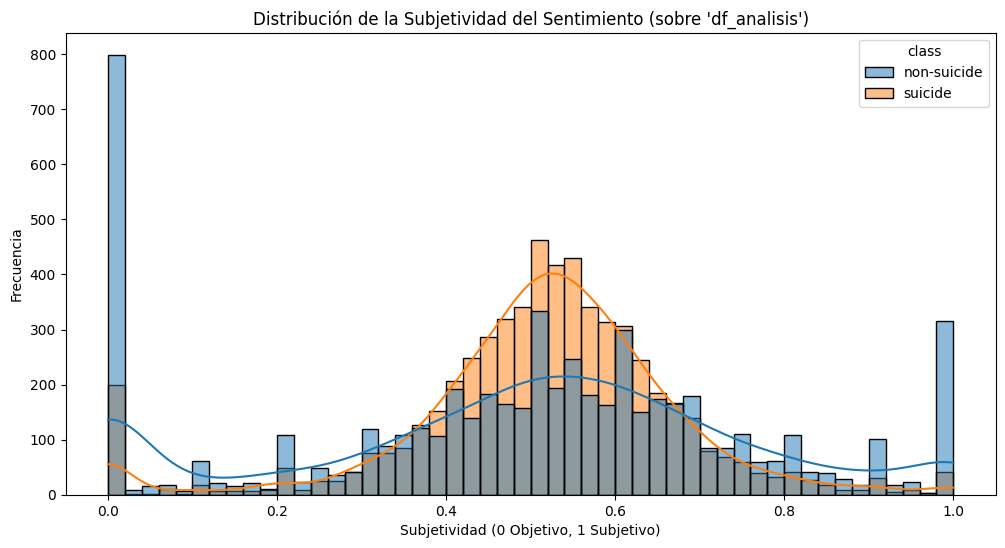

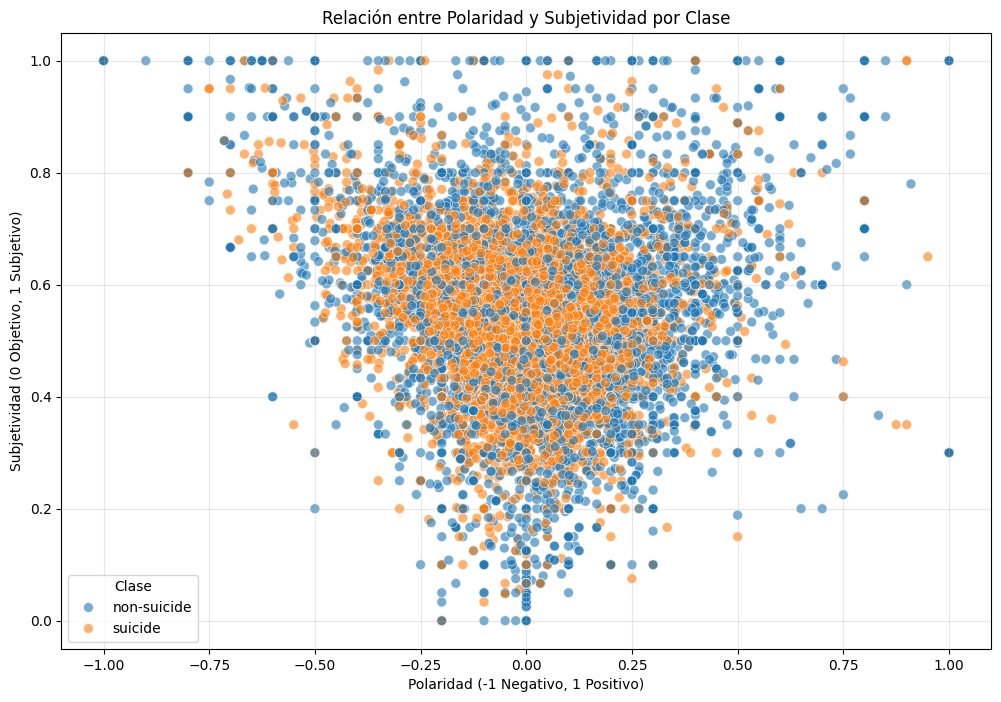

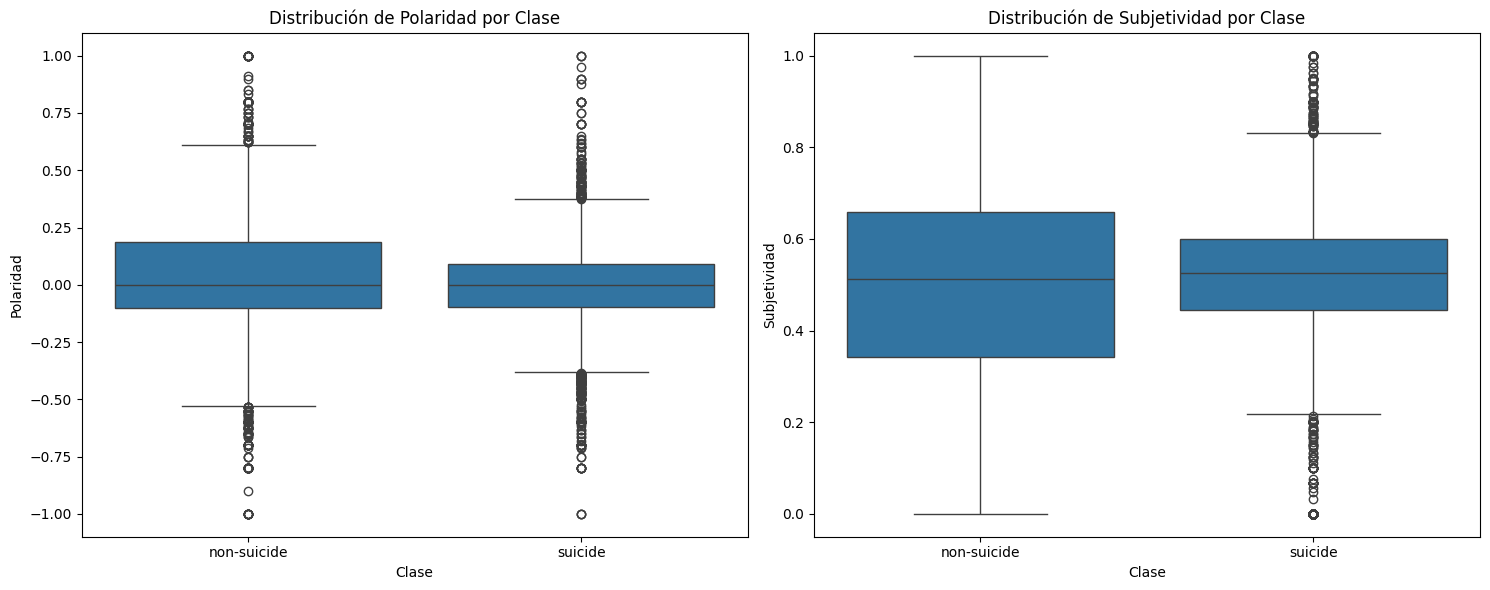


Estadísticas Descriptivas de Sentimiento por Clase

Polaridad:
              count      mean       std  min       25%  50%       75%  max
class                                                                     
non-suicide  5802.0  0.035122  0.278005 -1.0 -0.100000  0.0  0.187500  1.0
suicide      5802.0 -0.005111  0.187874 -1.0 -0.096518  0.0  0.092482  1.0

Subjetividad:
              count      mean       std  min       25%       50%       75%  \
class                                                                        
non-suicide  5802.0  0.485943  0.274888  0.0  0.342482  0.513148  0.659075   
suicide      5802.0  0.514224  0.164221  0.0  0.445699  0.524978  0.600000   

             max  
class             
non-suicide  1.0  
suicide      1.0  


In [34]:
# Visualización adicional: Distribución de subjetividad
plt.figure(figsize=(12, 6))
sns.histplot(data=df_analisis, x='subjectivity', hue='class', kde=True, bins=50)
plt.title("Distribución de la Subjetividad del Sentimiento (sobre 'df_analisis')")
plt.xlabel('Subjetividad (0 Objetivo, 1 Subjetivo)')
plt.ylabel('Frecuencia')
plt.show()

# Visualización: Scatter plot de Polaridad vs Subjetividad
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_analisis, x='polarity', y='subjectivity', hue='class', alpha=0.6, s=50)
plt.title("Relación entre Polaridad y Subjetividad por Clase")
plt.xlabel('Polaridad (-1 Negativo, 1 Positivo)')
plt.ylabel('Subjetividad (0 Objetivo, 1 Subjetivo)')
plt.legend(title='Clase')
plt.grid(True, alpha=0.3)
plt.show()

# Boxplots para comparar distribuciones
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.boxplot(data=df_analisis, x='class', y='polarity', ax=axes[0])
axes[0].set_title('Distribución de Polaridad por Clase')
axes[0].set_xlabel('Clase')
axes[0].set_ylabel('Polaridad')

sns.boxplot(data=df_analisis, x='class', y='subjectivity', ax=axes[1])
axes[1].set_title('Distribución de Subjetividad por Clase')
axes[1].set_xlabel('Clase')
axes[1].set_ylabel('Subjetividad')

plt.tight_layout()
plt.show()

# Estadísticas descriptivas por clase
print("\nEstadísticas Descriptivas de Sentimiento por Clase")
print("\nPolaridad:")
print(df_analisis.groupby('class')['polarity'].describe())
print("\nSubjetividad:")
print(df_analisis.groupby('class')['subjectivity'].describe())


### Clasificación con Embeddings 


In [35]:
# Usaremos el dataset completo 'data_classification'
# Asegurémonos de que no haya valores nulos en las columnas que usaremos
df_model = data_classification.dropna(subset=['text', 'gender', 'age_group_v3']).copy()

# frac=0.25 significa que tomamos el 25% de las filas.
# random_state=42 asegura que la muestra sea reproducible.
print(f"Tamaño original del dataset: {len(df_model)}")
df_model_subset = df_model.sample(frac=0.1, random_state=42)
print(f"Tamaño de la muestra para el prototipado: {len(df_model_subset)}")

# Definir nuestro target (y) y features (x) usando la muestra
y = df_model_subset['class']

# Escenario 1: Solo Texto
X_text = df_model_subset['text']

# Escenario 2: Texto + Género
le_gender = LabelEncoder()
X_gender_encoded = le_gender.fit_transform(df_model_subset['gender'])
X_text_gender = pd.DataFrame({'text': df_model_subset['text'], 'gender': X_gender_encoded})

# Escenario 3: Texto + Género + Edad
le_age = LabelEncoder()
X_age_encoded = le_age.fit_transform(df_model_subset['age_group_v3'])
X_text_gender_age = pd.DataFrame({
    'text': df_model_subset['text'], 
    'gender': X_gender_encoded, 
    'age': X_age_encoded
})

# Dividir los datos en entrenamiento y prueba (ahora con el subset)
X_train, X_test, y_train, y_test = train_test_split(
    X_text_gender_age, y, test_size=0.2, random_state=42, stratify=y
)

# Extraer los subconjuntos para cada escenario
X_train_text = X_train['text']
X_test_text = X_test['text']

X_train_text_gender = X_train[['text', 'gender']]
X_test_text_gender = X_test[['text', 'gender']]


# Cargar el Modelo y Generar Embeddings

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\nUtilizando el dispositivo: {device}")

print("Cargando modelo de embeddings...")
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
embedding_model.to(device)
embedding_model = embedding_model.half()

print("Generando embeddings para la muestra de entrenamiento y prueba...")
batch_size = 1024 

X_train_text_embeddings = embedding_model.encode(
    X_train_text.tolist(), 
    show_progress_bar=True,
    batch_size=batch_size
)

X_test_text_embeddings = embedding_model.encode(
    X_test_text.tolist(), 
    show_progress_bar=True,
    batch_size=batch_size
)

print("¡Codificación completada!")

Tamaño original del dataset: 232074
Tamaño de la muestra para el prototipado: 23207

Utilizando el dispositivo: cpu
Cargando modelo de embeddings...
Generando embeddings para la muestra de entrenamiento y prueba...


Batches: 100%|██████████| 5/5 [12:40<00:00, 152.08s/it]

¡Codificación completada!


In [41]:
import joblib
import os

# Crear directorio para artefactos
os.makedirs('model_artifacts', exist_ok=True)

# 1. Guardar los Encoders (Crítico para procesar nuevos datos igual que el training)
joblib.dump({
    'le_gender': le_gender,
    'le_age': le_age
}, 'model_artifacts/encoders.pkl')

# 2. Guardar los Embeddings (Esto evita esperar los 40 minutos de nuevo)
# Se guardan como arrays de numpy comprimidos
joblib.dump(X_train_text_embeddings, 'model_artifacts/X_train_embeddings.pkl')
joblib.dump(X_test_text_embeddings, 'model_artifacts/X_test_embeddings.pkl')

# 3. Guardar las etiquetas (y) y las features numéricas/categóricas auxiliares
# Es necesario guardar X_train/X_test completo o sus partes para mantener la alineación
data_splits = {
    'y_train': y_train,
    'y_test': y_test,
    'X_train_meta': X_train[['gender', 'age']], # Features numéricas ya codificadas
    'X_test_meta': X_test[['gender', 'age']]
}
joblib.dump(data_splits, 'model_artifacts/data_splits.pkl')

print("Configuración, encoders y embeddings guardados en carpeta 'model_artifacts'.")

Configuración, encoders y embeddings guardados en carpeta 'model_artifacts'.


In [ ]:
import joblib

# Cargar encoders
encoders = joblib.load('model_artifacts/encoders.pkl')
le_gender = encoders['le_gender']
le_age = encoders['le_age']

# Cargar embeddings (memoria inmediata, sin cálculo)
X_train_text_embeddings = joblib.load('model_artifacts/X_train_embeddings.pkl')
X_test_text_embeddings = joblib.load('model_artifacts/X_test_embeddings.pkl')

# Cargar resto de datos
splits = joblib.load('model_artifacts/data_splits.pkl')
y_train = splits['y_train']
y_test = splits['y_test']
X_train_meta = splits['X_train_meta'] # Columnas gender y age codificadas
X_test_meta = splits['X_test_meta']

print("Estado restaurado. Listo para entrenar el clasificador final.")

Entrenando y Evaluando el Modelo: Modelo 1: Solo Texto

Reporte de Clasificación:
              precision    recall  f1-score   support

 non-suicide       0.89      0.95      0.92      2340
     suicide       0.94      0.88      0.91      2302

    accuracy                           0.92      4642
   macro avg       0.92      0.92      0.92      4642
weighted avg       0.92      0.92      0.92      4642



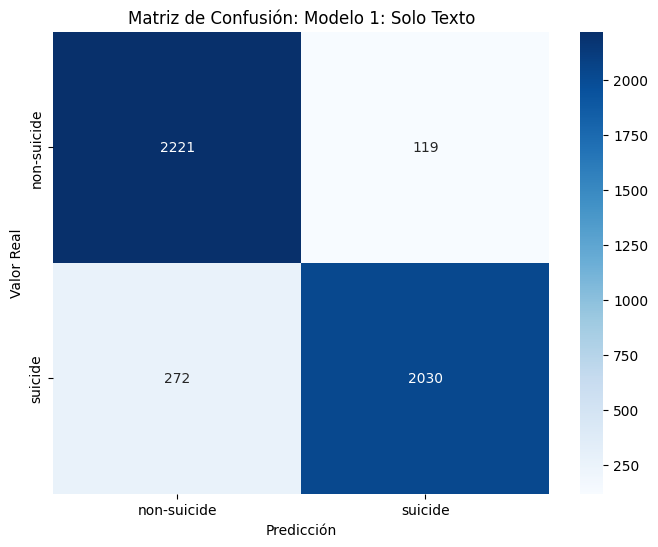

Entrenando y Evaluando el Modelo: Modelo 2: Texto + Género

Reporte de Clasificación:
              precision    recall  f1-score   support

 non-suicide       0.89      0.94      0.91      2340
     suicide       0.94      0.88      0.91      2302

    accuracy                           0.91      4642
   macro avg       0.91      0.91      0.91      4642
weighted avg       0.91      0.91      0.91      4642



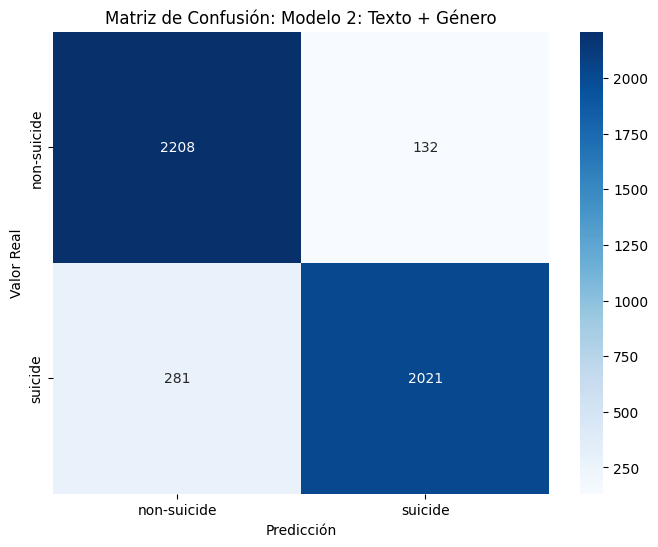

Entrenando y Evaluando el Modelo: Modelo 3: Texto + Género + Edad

Reporte de Clasificación:
              precision    recall  f1-score   support

 non-suicide       0.89      0.94      0.92      2340
     suicide       0.94      0.88      0.91      2302

    accuracy                           0.91      4642
   macro avg       0.91      0.91      0.91      4642
weighted avg       0.91      0.91      0.91      4642



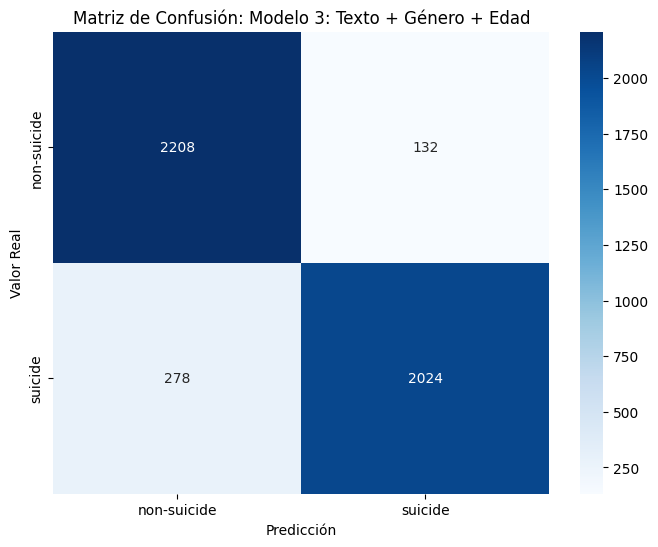

In [40]:
# Función para Entrenar, Evaluar y Visualizar

def train_and_evaluate_with_cm(X_train_features, X_test_features, y_train, y_test, model_name):
    """
    Combina características, entrena un modelo, muestra el reporte y la matriz de confusión.
    """
    print(f"Entrenando y Evaluando el Modelo: {model_name}")
    
    # Entrenar el modelo
    model = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100)
    model.fit(X_train_features, y_train)
    
    # Evaluar el modelo
    y_pred = model.predict(X_test_features)
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['non-suicide', 'suicide'], 
                yticklabels=['non-suicide', 'suicide'])
    
    plt.title(f'Matriz de Confusión: {model_name}')
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.show()


# Experimento 1: Solo Texto
train_and_evaluate_with_cm(
    X_train_text_embeddings, 
    X_test_text_embeddings, 
    y_train, 
    y_test, 
    "Modelo 1: Solo Texto"
)

# Experimento 2: Texto + Género
X_train_combined_gender = np.hstack((X_train_text_embeddings, X_train['gender'].values.reshape(-1, 1)))
X_test_combined_gender = np.hstack((X_test_text_embeddings, X_test['gender'].values.reshape(-1, 1)))

train_and_evaluate_with_cm(
    X_train_combined_gender, 
    X_test_combined_gender, 
    y_train, 
    y_test, 
    "Modelo 2: Texto + Género"
)

# Experimento 3: Texto + Género + Edad
X_train_combined_all = np.hstack((
    X_train_text_embeddings, 
    X_train['gender'].values.reshape(-1, 1),
    X_train['age'].values.reshape(-1, 1)
))
X_test_combined_all = np.hstack((
    X_test_text_embeddings, 
    X_test['gender'].values.reshape(-1, 1),
    X_test['age'].values.reshape(-1, 1)
))

train_and_evaluate_with_cm(
    X_train_combined_all, 
    X_test_combined_all, 
    y_train, 
    y_test, 
    "Modelo 3: Texto + Género + Edad"
)

## Inferencia y Análisis de los Resultados

**Rendimiento General Excepcional:**

Todos los modelos tienen un rendimiento excelente, con un f1-score de 0.91 para la clase suicide. Esto significa que son muy buenos tanto para encontrar la mayoría de los casos reales de suicidio (alto recall de 0.88) como para no cometer muchos errores al clasificar posts no suicidas (alta precision de 0.94). Un 91% de F1-score es un resultado muy sólido en una tarea de clasificación de texto.

**El Hallazgo Más Importante: No Hay Mejora Significativa:**

El resultado más interesante de tu experimento es que el rendimiento es prácticamente idéntico en los tres modelos.

* Modelo 1 (Solo Texto): F1-Score = 0.91
* Modelo 2 (Texto + Género): F1-Score = 0.91
* Modelo 3 (Texto + Género + Edad): F1-Score = 0.91

Añadir las características de género y edad no ha mejorado la capacidad del modelo para predecir si un post es sobre suicidio.


**¿Por Qué Ocurre Esto? El Poder de los Embeddings**

Este resultado subraya el poder de los embeddings de texto modernos (como los de all-MiniLM-L6-v2). Estos modelos son tan buenos capturando el significado, el tono, la emoción y el contexto de una frase que la señal semántica del texto es, por sí sola, suficiente para resolver el problema de clasificación.

La información demográfica (género, edad) o bien es redundante con lo que el modelo ya aprende del texto, o no añade una señal predictiva lo suficientemente fuerte como para mejorar el resultado.

Basado en estos resultados, la recomendación es clara: utiliza el Modelo 1 (Solo Texto) para tu aplicación final.

Justificación:

* Mismo Rendimiento: Logra el mismo nivel de precisión que los modelos más complejos.
* Más Simple: Es más fácil de implementar y mantener.
* Más Rápido: Requiere menos pasos de preprocesamiento (no necesitas codificar y combinar características adicionales).
* Más Escalable: Será más rápido de entrenar y de usar para hacer predicciones en nuevos datos.

Este es un ejemplo perfecto del principio de la navaja de Ockham: la solución más simple suele ser la mejor. Has demostrado de forma cuantitativa que la complejidad adicional no se justifica.

--- Procesando: Random Forest ---

Reporte de Clasificación (Random Forest):
              precision    recall  f1-score   support

 non-suicide       0.89      0.95      0.92      2340
     suicide       0.94      0.88      0.91      2302

    accuracy                           0.92      4642
   macro avg       0.92      0.92      0.92      4642
weighted avg       0.92      0.92      0.92      4642



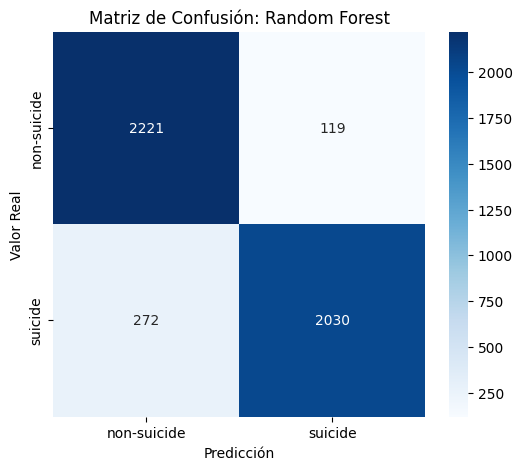

--- Procesando: SVM (Support Vector Machine) ---

Reporte de Clasificación (SVM (Support Vector Machine)):
              precision    recall  f1-score   support

 non-suicide       0.93      0.94      0.93      2340
     suicide       0.93      0.93      0.93      2302

    accuracy                           0.93      4642
   macro avg       0.93      0.93      0.93      4642
weighted avg       0.93      0.93      0.93      4642



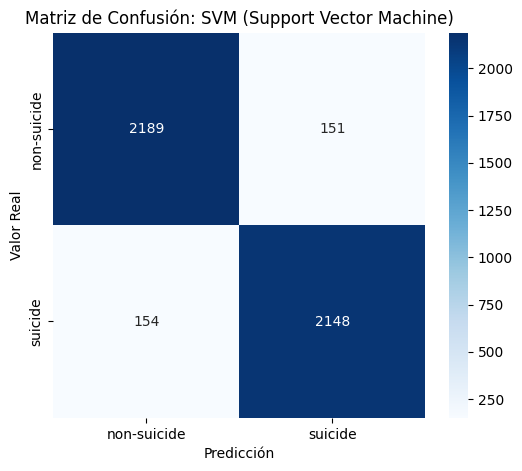

--- Procesando: XGBoost Classifier ---

Reporte de Clasificación (XGBoost Classifier):
              precision    recall  f1-score   support

 non-suicide       0.92      0.94      0.93      2340
     suicide       0.93      0.92      0.93      2302

    accuracy                           0.93      4642
   macro avg       0.93      0.93      0.93      4642
weighted avg       0.93      0.93      0.93      4642



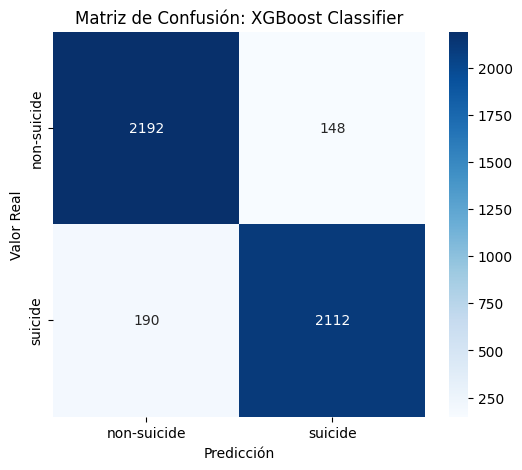

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Preparación de etiquetas (Indispensable para XGBoost)
le_target = LabelEncoder()
y_train_enc = le_target.fit_transform(y_train)
y_test_enc = le_target.transform(y_test)

# Mapeo inverso para visualizar la matriz de confusión con nombres reales
class_names = le_target.classes_

# 2. Función genérica de evaluación
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    print(f"--- Procesando: {model_name} ---")
    
    # Entrenar
    model.fit(X_train, y_train)
    
    # Predecir
    y_pred = model.predict(X_test)
    
    # Reporte
    print(f"\nReporte de Clasificación ({model_name}):")
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    # Matriz de Confusión
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    
    plt.title(f'Matriz de Confusión: {model_name}')
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.show()

# 3. Definición de modelos a comparar
models_to_test = [
    (
        "Random Forest", 
        RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    ),
    (
        "SVM (Support Vector Machine)", 
        SVC(kernel='linear', class_weight='balanced', random_state=42) # Kernel lineal suele ser mejor para embeddings de texto
    ),
    (
        "XGBoost Classifier", 
        XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
    )
]

# 4. Ejecución del bucle de comparación (Solo Embeddings)
for name, model in models_to_test:
    train_and_evaluate_model(
        model, 
        X_train_text_embeddings, 
        X_test_text_embeddings, 
        y_train_enc, 
        y_test_enc, 
        name
    )

### Visualizar la Separación de Clases en el Espacio de Embeddings




Generando proyección 3D...


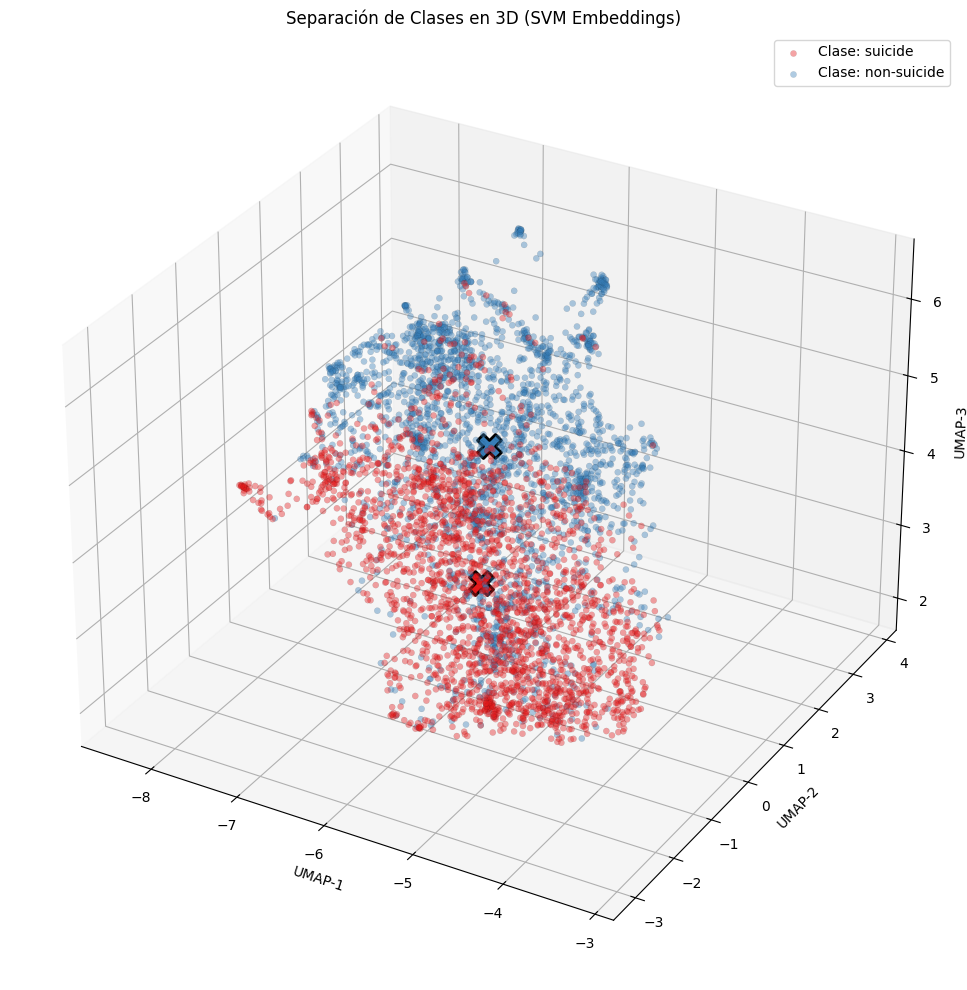

In [43]:
import umap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np

# 1. Configurar UMAP para 3 componentes (3D)
reducer = umap.UMAP(n_neighbors=15, n_components=3, min_dist=0.1, metric='cosine', random_state=42)
print("Generando proyección 3D...")
embedding_3d = reducer.fit_transform(X_test_text_embeddings)

# 2. Estructurar datos
df_viz = pd.DataFrame(embedding_3d, columns=['UMAP-1', 'UMAP-2', 'UMAP-3'])
# Asegurar que y_test sea un array unidimensional
df_viz['class'] = y_test if isinstance(y_test, np.ndarray) else y_test.values

# 3. Calcular Centroides
centroids = df_viz.groupby('class').mean()

# 4. Visualización 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Definir colores contrastantes (Set1)
# Asumiendo clasificación binaria o pocas clases. 
classes = df_viz['class'].unique()
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3'] # Rojo, Azul, Verde, Morado

for i, class_label in enumerate(classes):
    subset = df_viz[df_viz['class'] == class_label]
    color = colors[i % len(colors)]
    
    # Puntos de datos
    ax.scatter(
        subset['UMAP-1'], subset['UMAP-2'], subset['UMAP-3'],
        c=color,
        label=f'Clase: {class_label}',
        alpha=0.4,
        s=20,
        edgecolor='k',
        linewidth=0.1
    )
    
    # Centroide correspondiente
    centroid_coords = centroids.loc[class_label]
    ax.scatter(
        centroid_coords['UMAP-1'], centroid_coords['UMAP-2'], centroid_coords['UMAP-3'],
        c=color,
        s=300,
        marker='X',
        edgecolor='black',
        linewidth=2
    )

ax.set_title('Separación de Clases en 3D (SVM Embeddings)')
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')
ax.set_zlabel('UMAP-3')
ax.legend()
plt.tight_layout()
plt.show()

### Interpretación Léxica con SHAP

In [38]:
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
shap.initjs() 
# --- Paso A: Entrenar un Modelo Interpretable y Robusto (Logistic Regression) ---

# Mapeamos las etiquetas a 0 y 1 para un problema binario, lo que simplifica SHAP
y_train_binary = y_train.map({'non-suicide': 0, 'suicide': 1})
y_test_binary = y_test.map({'non-suicide': 0, 'suicide': 1})

# Usamos los mismos datos de entrenamiento y prueba que antes
vectorizer_tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train_text)
X_test_tfidf = vectorizer_tfidf.transform(X_test_text)

# Entrenar un modelo de Regresión Logística
# class_weight='balanced' ayuda con el desbalanceo de clases
interpretable_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
interpretable_model.fit(X_train_tfidf, y_train_binary)

# --- Paso B: Crear un Explainer SHAP y Analizar una Instancia ---

# Seleccionar una instancia para explicar
# Buscamos un ejemplo que fue correctamente clasificado como 'suicide' (ahora, clase 1)
correct_suicide_indices = np.where((y_test_binary == 1) & (interpretable_model.predict(X_test_tfidf) == 1))[0]
example_index_to_explain = correct_suicide_indices[0]

# 1. Crear un LinearExplainer, que es perfecto para modelos como la Regresión Logística
#    y mucho más rápido que los otros.
explainer = shap.LinearExplainer(interpretable_model, X_train_tfidf)

# 2. Calcular los valores SHAP para esa instancia
print(f"Calculando valores SHAP para el ejemplo #{example_index_to_explain}...")
# Convertimos la instancia a un array denso para evitar problemas de forma
instance_to_explain = X_test_tfidf[example_index_to_explain].toarray()
shap_values = explainer(instance_to_explain)

# --- Paso C: Visualizar la Explicación con el Gráfico Force (el más robusto) ---

print("\nTexto del ejemplo a analizar:")
print(X_test_text.iloc[example_index_to_explain])
print("\nExplicación de SHAP para la predicción 'suicide' (usando LinearExplainer):")

# 3. Usar el gráfico de fuerza, accediendo a los valores del objeto SHAP
#    - explainer.expected_value: es el valor base (la predicción promedio)
#    - shap_values.values[0]: son los valores SHAP para la instancia
#    - feature_names: son los nombres de las características (palabras)
feature_names = vectorizer_tfidf.get_feature_names_out()

# Este es el método más robusto y compatible con la mayoría de las versiones de SHAP
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values.values[0],
    feature_names=feature_names
)

Calculando valores SHAP para el ejemplo #0...

Texto del ejemplo a analizar:
i almost killed myself over her  now im begging her just to speak to me again   wtf is wrong with mei was hurt by someone i really cared about over unrequited love ive been through this before  seriously id sell my left nut just to be stuck in the friendzone at this point but she wont even talk to me and i cant get closure

how do i make it stop i dont want legal trouble for being a stalker  i dont want to kill myself i just never had any luck with those head shrink people and im fucking lonely and im fucking miserable

i dont want to die i just dont have a lot to live for i dont have a support system and im really really unhappy and painfully misunderstood by some of the people i thought i knew better than anyone

i need to let go how do i let go 



Explicación de SHAP para la predicción 'suicide' (usando LinearExplainer):


In [45]:
def predecir_y_explicar():
    """
    Pide al usuario un texto, lo clasifica y muestra una explicación de SHAP
    si la predicción es 'suicide'.
    """
    # Asegurarse de que el explainer de SHAP esté inicializado para Jupyter
    try:
        shap.initjs()
    except Exception:
        print("Nota: SHAP ya está inicializado o el entorno no lo requiere.")
        
    # Mapeo para traducir la predicción numérica a texto
    label_map = {0: 'non-suicide', 1: 'suicide'}
        
    while True:
        print("\n" + "_"*100)
        texto_usuario = input("Escribe un texto en inglés para analizar (o escribe 'salir' para terminar): ")
        
        if texto_usuario.lower() == 'salir':
            break
            
        if not texto_usuario.strip():
            print("Por favor, ingresa un texto válido.")
            continue

        try:
            # 1. Transformar el texto del usuario con el MISMO vectorizador
            texto_tfidf = vectorizer_tfidf.transform([texto_usuario])
            
            # 2. Hacer la predicción (esto devuelve un número, ej. 1)
            prediccion_num = interpretable_model.predict(texto_tfidf)[0]
            
            # 3. Traducir el número a la etiqueta de texto (ej. 1 -> 'suicide')
            prediccion_str = label_map[prediccion_num]
            
            # 4. Obtener las probabilidades para mostrar confianza
            probabilidades = interpretable_model.predict_proba(texto_tfidf)[0]
            prob_suicide = probabilidades[1] * 100
            prob_non_suicide = probabilidades[0] * 100

            print("\n--- Resultados de la Clasificación ---")
            print(f"Texto: '{texto_usuario}'")
            print(f"Predicción: {prediccion_str.upper()}")
            print(f"Probabilidad de 'Suicide': {prob_suicide:.2f}%")
            print(f"Probabilidad de 'Non-Suicide': {prob_non_suicide:.2f}%")

        except Exception as e:
            print(f"\nOcurrió un error al procesar el texto: {e}")
            print("Por favor, intenta con otro texto.")


# --- Ejecutar la Función Interactiva ---
predecir_y_explicar()


____________________________________________________________________________________________________

--- Resultados de la Clasificación ---
Texto: 'When you were here before, couldn't look you in the eye. You're just like an angel, your skin makes me cry. You float like a feather in a beautiful world. I wish I was special. You're so fuckin' special. But I'm a creep. I'm a weirdo. What the hell am I doing here? I don't belong here. I don't care if it hurts, I wanna have control. I want a perfect body, I want a perfect soul. I want you to notice when I'm not around. You're so fuckin' special. I wish I was special.'
Predicción: NON-SUICIDE
Probabilidad de 'Suicide': 41.76%
Probabilidad de 'Non-Suicide': 58.24%

____________________________________________________________________________________________________

--- Resultados de la Clasificación ---
Texto: 'I hurt myself today to see if I still feel. I focus on the pain, the only thing that's real. The needle tears a hole, the old famil